In [1]:
import os
from collections import OrderedDict
import logging

import numpy as np
from astropy.table import Table

import proxmin
import deblender

from lsst.meas.deblender import display as debDisplay

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty 
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
def gaussian2D(x, y, x0=0, y0=0, A=1, sigma=1.5):
    return A*np.exp(-0.5*((x-x0)**2+(y-y0)**2)/sigma)

width = 15
height = 15
img_shape = (height, width)

x = np.linspace(-7,7,width)
y = np.linspace(-7,7,height)
X,Y = np.meshgrid(x,y)

peaks = [
    (1.435, -1.108, 1, 1.5),
    (-3.108, -2.56, .6, 4)
]

deltas = [
    (-.126,-.102),
    (.314,.44)
]
model_peaks = [(px+deltas[n][0], py+deltas[n][1], A, sigma) for n,(px,py,A,sigma) in enumerate(peaks)]

A = np.array([
    [.15,.35,.23,.15,.12],
    [.05,.2,.33,.37,.15]
]).T

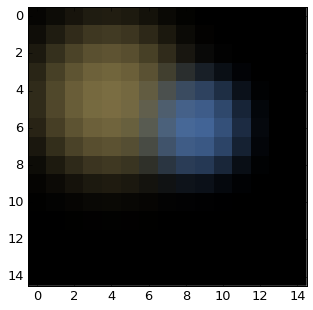

In [3]:
S = np.zeros((A.shape[1], height*width))
for k, (px,py,Amp,sigma) in enumerate(peaks):
    S[k] = gaussian2D(X, Y, 0, 0, Amp, sigma).flatten()

pks = [[px,py] for px, py, _, _ in peaks]
trans = deblender.operators.Translations(pks, img_shape)

model = deblender.nmf.get_model(A, S, trans.Tx, trans.Ty, shape=img_shape)
debDisplay.plotColorImage(model)

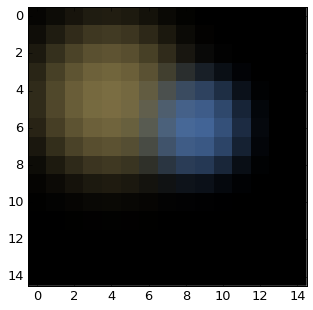

In [4]:
Tx = []
Ty = []
for k, (px, py, _, _) in enumerate(peaks):
#for k, (px, py) in enumerate(pks):
    tx, ty, _ = deblender.operators.getTranslationOp(-px, -py, img_shape)
    Tx.append(tx)
    Ty.append(ty)

model = deblender.nmf.get_model(A, S, Tx, Ty, shape=img_shape)
debDisplay.plotColorImage(model)

In [9]:
for n in range(len(peaks)):
    print(np.max((Tx[n]-trans.Tx[n]).toarray()))
    print(np.max((Ty[n]-trans.Ty[n]).toarray()))

0.0
0.0
0.0
0.0


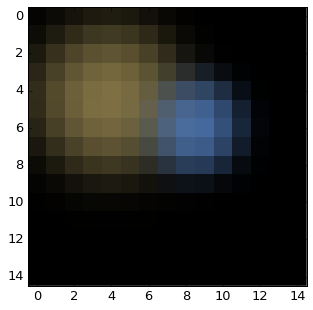

In [10]:
S = np.zeros((A.shape[1], height*width))
for k, (px,py,Amp,sigma) in enumerate(peaks):
    S[k] = gaussian2D(X, Y, px, py, Amp, sigma).flatten()
data = A.dot(S)

residual = data.reshape(A.shape[0],height, width)-model
debDisplay.plotColorImage(data.reshape(A.shape[0], height, width))

0.089189799819


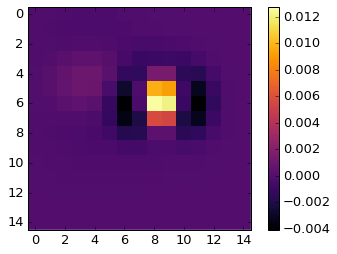

0.0877364798395


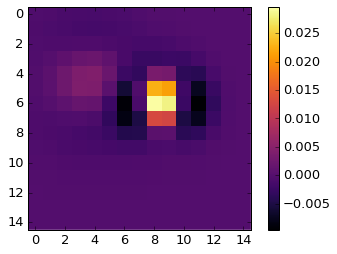

0.0827744955119


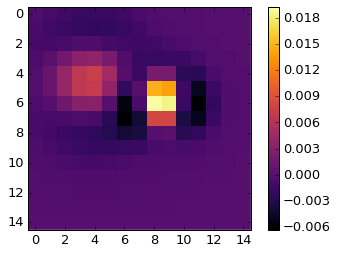

0.0774091575892


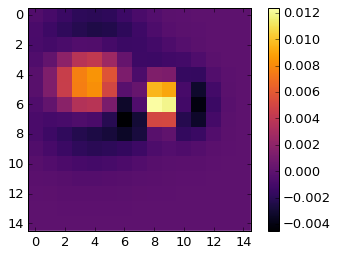

0.0837979001618


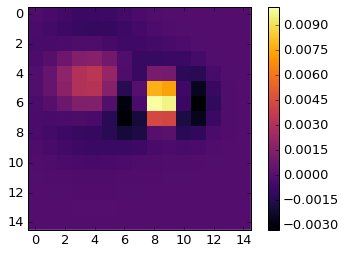

In [11]:
for n in range(len(data)):
    dn = data[n].reshape(height, width)
    idx = np.argmax(residual[n])
    idx = np.unravel_index(idx, dn.shape)
    print(residual[n][idx]/dn[idx])
    plt.imshow(residual[n])
    plt.colorbar()
    plt.show()
    #plt.imshow(dn)
    #plt.colorbar()
    #plt.show()